# **<font style="color:rgb(0, 133, 202)">Video Classification Task - Jestures</font>**

This dataset consists of **5 gestures**, each with **30 frames** in sequence for each sample.

Each gesture corresponds to a specific command:

- **Thumbs up**: Increase the volume
- **Thumbs down**: Decrease the volume
- **Left swipe**: 'Jump' backward 10 seconds
- **Right swipe**: 'Jump' forward 10 seconds
- **Stop**: Pause the movie

Each video is a sequence of **30 frames** (or images).

The data includes a **'train'** and a **'val'** folder, each containing two CSV files corresponding to the respective folders. These folders are further divided into **subfolders**, with each subfolder representing a video of a specific gesture. Each subfolder (i.e., a video) contains **30 frames** (or images). Note that all images in a particular video subfolder have the same dimensions, but different videos may have different dimensions. Specifically, videos have two types of dimensions: either **360x360** or **120x160** (depending on the webcam used to record the videos).

Each row in the CSV file represents one video and contains three main pieces of information:
- The name of the subfolder containing the 30 images of the video sample (gesture)
- The name of the gesture
- The numeric label (ranging from 0-4) of the video

The **goal** of this project is to train models that can accurately recognize the **five gestures**.

**Reference:** [Link](https://www.kaggle.com/datasets/imsparsh/gesture-recognition)

**Note**: The images are *mirrored*, so swipe gestures will appear inverted in the video (e.g., a right swipe will show the right hand moving from right to left, even though, in reality, the person is performing the motion from left to right). Remember that gestures are often performed with right-hand.

In [1]:
import pandas as pd
import regex as re
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras

## **<font style="color:rgb(0, 133, 202)">1. Import Data and Preliminar Cleaning</font>**

The data available for this project consists of **videos**. Each video is divided into **30 frames**, extracted at equal intervals from the corresponding original video. Each video is associated with a folder named after the video itself, and each folder contains the extracted frames. The folders corresponding to the videos are further distributed into two directories: **train** and **val**. These subsets already represent the training and validation datasets to be used for estimating classification models for the video classification task.

These two directories are located within the project’s repository, named `jesture`, which also contains two CSV files: `train.csv` and `val.csv`. These files list the videos within their respective subsets, including the video names, their corresponding class in string format, and another field with the class in numeric format.

**Note**: The term *val* can be misleading, as this data will actually be used as the test set, not for validation. Model validation will instead be performed on a subset of the training set, ensuring the proper evaluation of the model during training.

In [54]:
# Analyze training data
train_desc = pd.read_csv('jesture/train.csv', sep=';', header=None).rename(columns={0:'File_Name',
                                                                                1: 'Jesture',
                                                                                2: 'Jesture_Class'})
train_desc

File_Name         Jesture  Jesture_Class
0    WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new              0
1    WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new              0
2    WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new              0
3    WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new              0
4    WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new              0
..                                        ...             ...            ...
658   WIN_20180907_16_38_23_Pro_Thumbs Up_new   Thumbs Up_new              4
659   WIN_20180907_16_41_09_Pro_Thumbs Up_new   Thumbs Up_new              4
660   WIN_20180907_16_42_05_Pro_Thumbs Up_new   Thumbs Up_new              4
661   WIN_20180907_16_42_55_Pro_Thumbs Up_new   Thumbs Up_new              4
662   WIN_20180907_16_43_39_Pro_Thumbs Up_new   Thumbs Up_new              4

[663 rows x 3 columns]

In [55]:
# Analyze test data
val_desc = pd.read_csv('jesture/val.csv', sep=';', header=None).rename(columns={0:'File_Name',
                                                                                1: 'Jesture',
                                                                                2: 'Jesture_Class'})
val_desc

File_Name         Jesture  Jesture_Class
0   WIN_20180925_17_17_04_Pro_Left_Swipe_new  Left_Swipe_new              0
1   WIN_20180925_17_43_01_Pro_Left_Swipe_new  Left_Swipe_new              0
2   WIN_20180925_18_01_40_Pro_Left_Swipe_new  Left_Swipe_new              0
3   WIN_20180925_18_03_21_Pro_Left_Swipe_new  Left_Swipe_new              0
4   WIN_20180926_16_46_22_Pro_Left_Swipe_new  Left_Swipe_new              0
..                                       ...             ...            ...
95   WIN_20180907_15_43_36_Pro_Thumbs Up_new   Thumbs Up_new              4
96   WIN_20180907_15_52_05_Pro_Thumbs Up_new   Thumbs Up_new              4
97   WIN_20180907_15_54_30_Pro_Thumbs Up_new   Thumbs Up_new              4
98   WIN_20180907_16_10_59_Pro_Thumbs Up_new   Thumbs Up_new              4
99   WIN_20180907_16_39_59_Pro_Thumbs Up_new   Thumbs Up_new              4

[100 rows x 3 columns]

The dataset is composed by:
- **663 videos** within the training set
- **100 videos** in the test set

Then, videos are classified into **5 different classes**. Let's check how data are distributed across them:

In [56]:
# Check data and class distribution over training set
train_desc.Jesture.value_counts()

Jesture
Right_Swipe_new                  103
Thumbs_Down_new                  100
Left_Swipe_new                    96
Stop_new                          93
Thumbs_Up_new                     87
Left Swipe_new_Left Swipe_new     40
Stop Gesture_new                  37
Thumbs Down_new                   37
Thumbs Up_new                     36
Right Swipe_new                   34
Name: count, dtype: int64

In [57]:
# Check data and class distribution over validation set
train_desc[['Jesture','Jesture_Class']].value_counts().sort_index()

Jesture                        Jesture_Class
Left Swipe_new_Left Swipe_new  0                 40
Left_Swipe_new                 0                 96
Right Swipe_new                1                 34
Right_Swipe_new                1                103
Stop Gesture_new               2                 37
Stop_new                       2                 93
Thumbs Down_new                3                 37
Thumbs Up_new                  4                 36
Thumbs_Down_new                3                100
Thumbs_Up_new                  4                 87
Name: count, dtype: int64

The **class names** appear to be rather **messy**, so a cleaning process is necessary.

First, spaces should be replaced with underscores (_) to standardize the initial inconsistencies.

In [58]:
# Class Cleaning
def string_cleaning(string):
    new = re.sub(' ', '_', string)
    return new

train_desc.Jesture = train_desc.Jesture.apply(string_cleaning)
val_desc.Jesture = val_desc.Jesture.apply(string_cleaning)

In [59]:
# Check data and class distribution over training and validation sets
print('Training Set: ')
train_desc[['Jesture','Jesture_Class']].value_counts().sort_index()

Training Set: 


Jesture                        Jesture_Class
Left_Swipe_new                 0                 96
Left_Swipe_new_Left_Swipe_new  0                 40
Right_Swipe_new                1                137
Stop_Gesture_new               2                 37
Stop_new                       2                 93
Thumbs_Down_new                3                137
Thumbs_Up_new                  4                123
Name: count, dtype: int64

In [60]:
print('Test Set: ')
val_desc[['Jesture','Jesture_Class']].value_counts().sort_index()

Test Set: 


Jesture                        Jesture_Class
Left_Swipe_new                 0                13
Left_Swipe_new_Left_Swipe_new  0                 5
Right_Swipe_new                1                23
Stop_Gesture_new               2                 8
Stop_new                       2                14
Thumbs_Down_new                3                21
Thumbs_Up_new                  4                16
Name: count, dtype: int64

The last classes to clean are `class 0` and `class 2`. The incorrect values for `Jesture` should be replaced with their appropriate, clean versions.

In [61]:
class_cl = {'Left_Swipe_new_Left_Swipe_new': 'Left_Swipe_new',
            'Stop_Gesture_new': 'Stop_new'}
def string_cleaning2(string):
    if string in class_cl:
        new = class_cl[string]
    else:
        new = string
    return new

In [62]:
train_desc.Jesture = train_desc.Jesture.apply(string_cleaning2)
val_desc.Jesture = val_desc.Jesture.apply(string_cleaning2)

Check the final result:

In [63]:
# Check data and class distribution over training and validation sets
print('Training Set: ')
train_desc[['Jesture','Jesture_Class']].value_counts(normalize=True).sort_index()

Training Set: 


Jesture          Jesture_Class
Left_Swipe_new   0                0.205128
Right_Swipe_new  1                0.206637
Stop_new         2                0.196078
Thumbs_Down_new  3                0.206637
Thumbs_Up_new    4                0.185520
Name: proportion, dtype: float64

In [64]:
print('Test Set: ')
val_desc[['Jesture','Jesture_Class']].value_counts(normalize=True).sort_index()

Test Set: 


Jesture          Jesture_Class
Left_Swipe_new   0                0.18
Right_Swipe_new  1                0.23
Stop_new         2                0.22
Thumbs_Down_new  3                0.21
Thumbs_Up_new    4                0.16
Name: proportion, dtype: float64

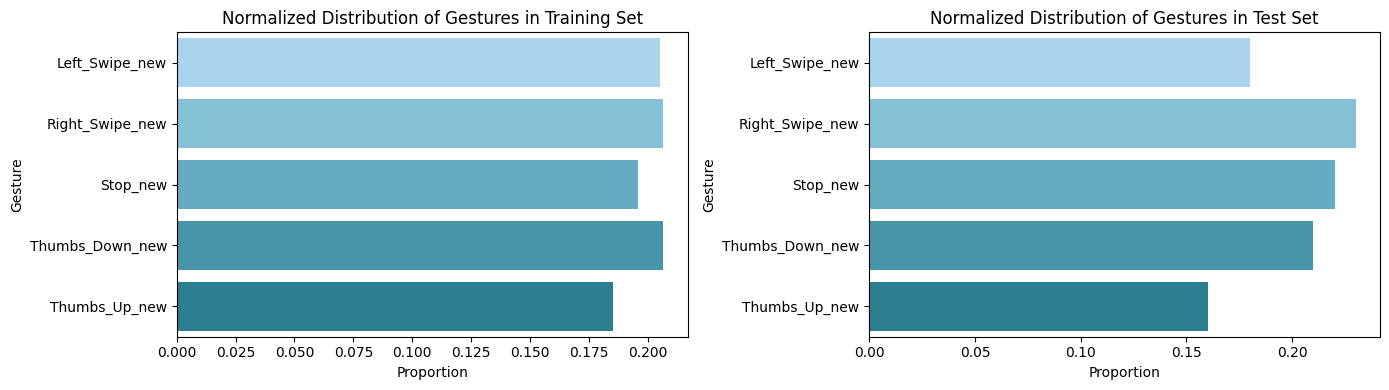

In [65]:
# Define a custom blue-cyan color palette
custom_palette = sns.color_palette(['#9DD9F7', '#79C6E3', '#55B3CF', '#379FB8', '#1A8AA1'])

# Normalized counts for the training and validation sets
train_data = train_desc[['Jesture', 'Jesture_Class']].value_counts(normalize=True).sort_index().reset_index()
val_data = val_desc[['Jesture', 'Jesture_Class']].value_counts(normalize=True).sort_index().reset_index()

# Rename the columns for convenience
train_data.columns = ['Jesture', 'Jesture_Class', 'Normalized_Count']
val_data.columns = ['Jesture', 'Jesture_Class', 'Normalized_Count']

# Create the figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot for the Training Set (horizontal bars)
sns.barplot(x='Normalized_Count', y='Jesture', hue='Jesture_Class', data=train_data, palette=custom_palette, ax=axes[0])
axes[0].set_title('Normalized Distribution of Gestures in Training Set')
axes[0].set_xlabel('Proportion')
axes[0].set_ylabel('Gesture')
axes[0].legend().set_visible(False)  # Remove legend for training plot

# Plot for the Validation Set (horizontal bars)
sns.barplot(x='Normalized_Count', y='Jesture', hue='Jesture_Class', data=val_data, palette=custom_palette, ax=axes[1])
axes[1].set_title('Normalized Distribution of Gestures in Test Set')
axes[1].set_xlabel('Proportion')
axes[1].set_ylabel('Gesture')
axes[1].legend().set_visible(False)  # Remove legend for validation plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

The classes in which the data is distributed are as follows:

| Jesture               | Jesture_Class |
|---------------------|---------------|
| Left_Swipe_new      | 0             |
| Right_Swipe_new     | 1             |
| Stop_new            | 2             |
| Thumbs_Down_new     | 3             |
| Thumbs_Up_new       | 4             |

As shown in the distributions above, the classes are clearly well-balanced in general, but they are also balanced within the two datasets (training and validation).

Next, let's assess the proportion used for the split between the **training set** and the **test set** to determine whether this distribution is appropriate or if **redistribution** is necessary.

In [14]:
overall_data = pd.concat([train_desc, val_desc])
overall_data

File_Name         Jesture  Jesture_Class
0   WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new              0
1   WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new              0
2   WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new              0
3   WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new              0
4   WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new              0
..                                       ...             ...            ...
95   WIN_20180907_15_43_36_Pro_Thumbs Up_new   Thumbs_Up_new              4
96   WIN_20180907_15_52_05_Pro_Thumbs Up_new   Thumbs_Up_new              4
97   WIN_20180907_15_54_30_Pro_Thumbs Up_new   Thumbs_Up_new              4
98   WIN_20180907_16_10_59_Pro_Thumbs Up_new   Thumbs_Up_new              4
99   WIN_20180907_16_39_59_Pro_Thumbs Up_new   Thumbs_Up_new              4

[763 rows x 3 columns]

In [15]:
train_class_dist = list(train_desc[['Jesture']].value_counts(normalize=False).sort_index())

In [16]:
overall_class_dist = list(overall_data[['Jesture']].value_counts(normalize=False).sort_index())

In [17]:
np.mean([train_class_dist[x]/overall_class_dist[x] for x in range(len(train_class_dist))])

0.8693221469874983

The split between the **training set** and the **test set** with an **87-13% ratio** represents a commonly accepted standard for machine learning projects, especially when the dataset is of reasonable size. With this partition, the model has a sufficient amount of data in the training set to learn effectively, while ensuring an adequate test set to assess performance during training.

Moreover, the class distribution in the training set is balanced and reflects the overall distribution, minimizing the risk of bias during learning. Since each video consists of **30 frames**, the total number of samples is large enough to provide good variability for training, reducing the need to further resize the sets. Under these conditions, maintaining the existing proportion strikes a balance between **learning quality** and **test reliability**, without compromising model effectiveness.

It is important to check if the descriptions in the CSV files correspond to the data present in the folders, as this correspondence is necessary since the CSV files track the **actual classification**. This step ensures that the data referenced in the CSV files aligns with the **extracted frames** in the corresponding folders, which is crucial for maintaining consistency and accuracy in model training and evaluation.

In [18]:
# Read File Names
file_names = os.listdir('jesture/train')

# Remove .DS_Store Files
for file in file_names:
    if file == '.DS_Store':
        file_per_eliminare = os.path.join('jesture/train', file)
        os.remove(file_per_eliminare)

file_names = os.listdir('jesture/train')

In [19]:
# Sort lists of file names in each set
file_names.sort()
train_file_names = train_desc.File_Name.to_list()
train_file_names.sort()

In [20]:
file_names == train_file_names

True

The training set is okay. Now, repeat also for the test set.

In [21]:
# Read File Names
file_names = os.listdir('jesture/val')

# Remove .DS_Store Files
for file in file_names:
    if file == '.DS_Store':
        file_per_eliminare = os.path.join('jesture/val', file)
        os.remove(file_per_eliminare)

file_names = os.listdir('jesture/val')

In [22]:
# Sort lists of file names in each set
file_names.sort()
val_file_names = val_desc.File_Name.to_list()
val_file_names.sort()

In [23]:
file_names == val_file_names

True

Also the test set is clean. Now, it is possible to begin with the analysis.

## **<font style="color:rgb(0, 133, 202)">2. Organize Data</font>**

To perform video classification, the videos must be organized in the following structure:

```    
    /dataset
        /training_set
            /class_0
            /class_1
            /class_2
            /class_3
            /class_4

        /validation_set
            /class_0
            /class_1
            /class_2
            /class_3
            /class_4
```
This structure ensures that the videos are grouped by their respective classes within both the **training** and **validation** sets. Each **class** folder contains videos belonging to the respective gesture class.

In [66]:
# Define source and destination paths
source_train_folder = 'jesture/train'  # Folder where the original training data is located
source_val_folder = 'jesture/val'      # Folder where the original test data is located

destination_train_folder = 'jesture/training_set'
destination_val_folder = 'jesture/test_set'

# Create the new main destination folders if they don't exist
os.makedirs(destination_train_folder, exist_ok=True)
os.makedirs(destination_val_folder, exist_ok=True)

# Create the class folders in the destination directories if they don't exist
for i in range(5):  # Since you have 5 gestures/classes (0-4)
    os.makedirs(os.path.join(destination_train_folder, str(i)), exist_ok=True)
    os.makedirs(os.path.join(destination_val_folder, str(i)), exist_ok=True)

# Function to copy video folders based on the CSV classification
def copy_videos_from_csv(df, source_folder, destination_folder):
    for index, row in df.iterrows():
        video_folder_name = row['File_Name']  # Folder containing 30 frames
        gesture_class = str(row['Jesture_Class'])  # Class label as string (0-4)

        # Define source and destination paths for this video folder
        source_video_folder = os.path.join(source_folder, video_folder_name)
        destination_video_folder = os.path.join(destination_folder, gesture_class, video_folder_name)

        # Only copy if the video folder does not exist in the destination
        if not os.path.exists(destination_video_folder):  # Check if the folder already exists in destination
            if os.path.exists(source_video_folder):  # Check if the source folder exists
                shutil.copytree(source_video_folder, destination_video_folder)
            else:
                print(f"Warning: Folder {source_video_folder} does not exist.")
        else:
            print(f"Info: Folder {destination_video_folder} already exists. Skipping...")

# Copy videos for training and validation
copy_videos_from_csv(train_desc, source_train_folder, destination_train_folder)
copy_videos_from_csv(val_desc, source_val_folder, destination_val_folder)

print("Videos have been successfully copied.")

Videos have been successfully copied.


This procedure is designed to organize video data into **training_set** and **test_set** directories, ensuring that videos are classified into appropriate subfolders based on their gesture class. Here's a summary of its functionality:

1. **Define Paths**:
   The script begins by defining **source paths** for the original video data (**train** and **val** folders) and **destination paths** for the new dataset structure (**training_set** and **test_set**).

2. **Check and Create Directories**:
   It checks if the **destination directories** exist, creating them if necessary, along with subfolders for each of the 5 gesture classes (**0-4**).

3. **Read CSV Files**:
   The script then reads the **CSV files** containing the video folder names and their corresponding class labels.

4. **Copy Video Folders**:
   For each entry, it checks if the corresponding **video folder** already exists in the destination. If not, it copies the video folder containing **30 frames** from the source to the appropriate class subfolder.

5. **Avoid Redundancy**:
   The script ensures that no existing folders are overwritten, providing a message when skipping a folder that has already been copied.

Check correctness:

In [67]:
# Function to get the number of video folders in each class folder
def count_videos_in_folders(dataset_path):
    class_counts = {}

    # Loop through each class folder (0-4)
    for class_id in range(5):
        class_folder_path = os.path.join(dataset_path, str(class_id))

        # Check if the class folder exists
        if os.path.exists(class_folder_path):
            # List the contents of the class folder and count the number of video folders
            video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]
            class_counts[class_id] = len(video_folders)
        else:
            class_counts[class_id] = 0  # If the class folder doesn't exist, count is 0

    return class_counts

# Count videos in training and validation sets
training_set_counts = count_videos_in_folders(destination_train_folder)
validation_set_counts = count_videos_in_folders(destination_val_folder)

# Print the counts
print("Training Set Counts:")
for class_id, count in training_set_counts.items():
    print(f"Class {class_id}: {count} videos")

print("\nTest Set Counts:")
for class_id, count in validation_set_counts.items():
    print(f"Class {class_id}: {count} videos")

Training Set Counts:
Class 0: 136 videos
Class 1: 137 videos
Class 2: 130 videos
Class 3: 137 videos
Class 4: 123 videos

Test Set Counts:
Class 0: 18 videos
Class 1: 23 videos
Class 2: 22 videos
Class 3: 21 videos
Class 4: 16 videos


In [68]:
print('Training Set: ')
train_desc[['Jesture','Jesture_Class']].value_counts(normalize=False).sort_index()

Training Set: 


Jesture          Jesture_Class
Left_Swipe_new   0                136
Right_Swipe_new  1                137
Stop_new         2                130
Thumbs_Down_new  3                137
Thumbs_Up_new    4                123
Name: count, dtype: int64

In [69]:
print('Test Set: ')
val_desc[['Jesture','Jesture_Class']].value_counts(normalize=False).sort_index()

Test Set: 


Jesture          Jesture_Class
Left_Swipe_new   0                18
Right_Swipe_new  1                23
Stop_new         2                22
Thumbs_Down_new  3                21
Thumbs_Up_new    4                16
Name: count, dtype: int64

Videos are correctly copied into new directories.

## **<font style="color:rgb(0, 133, 202)">3. Resize Frames and Visualize Data</font>**

**Resizing** the data is a crucial step in the preparation of a video classification model, particularly when the dataset consists of videos with varying dimensions. Infact, this dataset includes videos of 30 frames, but the **frame sizes are not uniform**: some videos have dimensions of **360x360**, while others are **120x160** (as described within dataset overview).

This variability in image size can create challenges for neural networks, which generally require consistent input dimensions for effective training. By resizing all frames to a uniform size, such as **64x64**, the model can process the data without encountering issues related to mismatched input sizes. Furthermore, resizing ensures that the network can focus on learning relevant patterns from the gesture sequences rather than dealing with unnecessary computational complexity due to varying image resolutions.

In [70]:
# Function to resize all frames in a given video folder
def resize_video_frames(video_folder, target_size=(64, 64)):
    resized_frames = []

    # Loop through each frame in the video folder
    for frame_name in sorted(os.listdir(video_folder)):
        frame_path = os.path.join(video_folder, frame_name)

        # Only process image files (skip any non-image files)
        if os.path.isfile(frame_path):
            # Open the image frame
            img = Image.open(frame_path)

            # Resize the image to the target size
            img_resized = img.resize(target_size)

            # Convert to numpy array and append to the list
            resized_frames.append(np.array(img_resized))

    return resized_frames

Now, apply the `resized_frames` function to each video folder (and so, to its frames). Then, save new data.

In [71]:
# Function to apply resizing to all frames in all video folders within a class folder
def resize_all_videos_in_class(dataset_path, target_size=(64, 64)):
    resized_data = {}

    # Loop through each class folder (0-4)
    for class_id in range(5):
        class_folder_path = os.path.join(dataset_path, str(class_id))

        # Check if the class folder exists
        if os.path.exists(class_folder_path):
            video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]
            resized_data[class_id] = {}

            # Loop through each video folder in the class
            for video_folder in video_folders:
                video_folder_path = os.path.join(class_folder_path, video_folder)

                # Resize all frames in the video folder and store the result
                resized_frames = resize_video_frames(video_folder_path, target_size)
                resized_data[class_id][video_folder] = resized_frames

        else:
            resized_data[class_id] = {}

    return resized_data

In [72]:
# Function to check if the destination folder exists
def check_and_create_destination_folder(destination_path):
    if os.path.exists(destination_path):
        print(f"Data already resized in '{destination_path}'")
        return False
    else:
        os.makedirs(destination_path, exist_ok=True)
        return True

# Modified function to save resized frames
def save_resized_frames(source_folder, destination_path):
    # Check if the destination folder already exists
    if not check_and_create_destination_folder(destination_path):
        return  # Exit the function if data is already resized

    # Resize Frames
    resized_data = resize_all_videos_in_class(source_folder, target_size=(224, 224))

    for class_id, video_data in resized_data.items():
        for video_folder, frames in video_data.items():
            # Create the corresponding video folder in the destination path
            destination_video_folder = os.path.join(destination_path, str(class_id), video_folder)
            os.makedirs(destination_video_folder, exist_ok=True)

            # Save each resized frame as an image file
            for idx, frame in enumerate(frames):
                frame_img = Image.fromarray(frame)
                frame_img.save(os.path.join(destination_video_folder, f"{idx:03d}.jpg"))

    print(f"Resized frames have been successfully saved to '{destination_path}'")

# Save resized frames to a new folder for training and validation sets
save_resized_frames(destination_train_folder, 'jesture/training_set_resized')
save_resized_frames(destination_val_folder, 'jesture/test_set_resized')

Resized frames have been successfully saved to 'jesture/training_set_resized'
Resized frames have been successfully saved to 'jesture/test_set_resized'


Check if the function worked correctly.

In [73]:
# Count videos in training and validation sets
training_set_counts = count_videos_in_folders('jesture/training_set_resized')
validation_set_counts = count_videos_in_folders('jesture/test_set_resized')

# Print the counts
print("Training Set Counts:")
sum_count = 0
for class_id, count in training_set_counts.items():
    sum_count += count

print(f"Tot videos: {sum_count} videos")

print("\nTest Set Counts:")
sum_count = 0
for class_id, count in validation_set_counts.items():
    sum_count += count

print(f"Tot videos: {sum_count} videos")

Training Set Counts:
Tot videos: 663 videos

Test Set Counts:
Tot videos: 100 videos


Analyze with a plot the resize result:

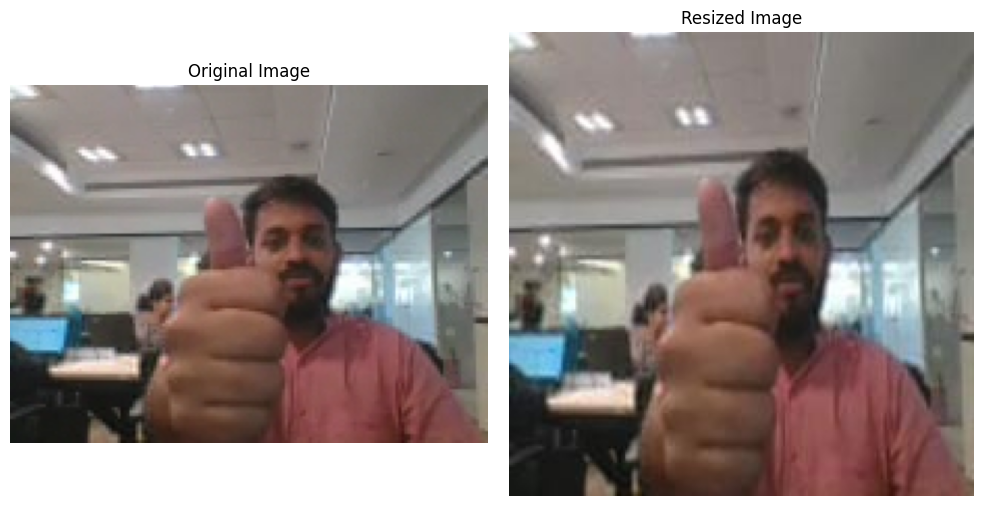

In [74]:
# Define the path to your training set and resized training set
original_training_set_path = 'jesture/training_set'
resized_training_set_path = 'jesture/training_set_resized'

# Function to get a random image from a given video folder
def get_random_frame_image(class_folder_path):
    video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]
    random.seed(1)
    selected_video_folder = random.choice(video_folders)
    video_folder_path = os.path.join(class_folder_path, selected_video_folder)

    # Choose a random frame from the selected video folder
    frames = [f for f in sorted(os.listdir(video_folder_path))]
    selected_frame = random.choice(frames)
    frame_path = os.path.join(video_folder_path, selected_frame)

    # Open and return the frame image
    return Image.open(frame_path)

# Choose a class randomly from the 5 classes (0 to 4)
class_id = random.randint(0, 4)

# Get random frame images from the original and resized training sets
original_image = get_random_frame_image(os.path.join(original_training_set_path, str(class_id)))
resized_image = get_random_frame_image(os.path.join(resized_training_set_path, str(class_id)))

# Plot the two images side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')

# Display the resized image
axes[1].imshow(resized_image)
axes[1].axis('off')
axes[1].set_title('Resized Image')

# Show the plot
plt.tight_layout()
plt.show()

It is now possible to free up space by removing the training and validation set folders containing the unresized frames.

In [75]:
# Function to delete a folder
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        try:
            shutil.rmtree(folder_path)  # Remove the folder and its contents
            print(f"Folder '{folder_path}' has been deleted successfully.")
        except Exception as e:
            print(f"Error while deleting folder '{folder_path}': {e}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

delete_folder('jesture/training_set')
delete_folder('jesture/test_set')

Folder 'jesture/training_set' has been deleted successfully.
Folder 'jesture/test_set' has been deleted successfully.


## **<font style="color:rgb(0, 133, 202)">4. Data Overview</font>**

Let's visualize some data samples for each class:

In [76]:
# Define a class dictionary
class_dict = dict()
class_ls = list(train_desc[['Jesture', 'Jesture_Class']].value_counts().index)

for x in range(len(class_ls)):
    key = class_ls[x][1]
    value = class_ls[x][0]
    class_dict[key] = value

class_dict

{1: 'Right_Swipe_new',
 3: 'Thumbs_Down_new',
 0: 'Left_Swipe_new',
 2: 'Stop_new',
 4: 'Thumbs_Up_new'}

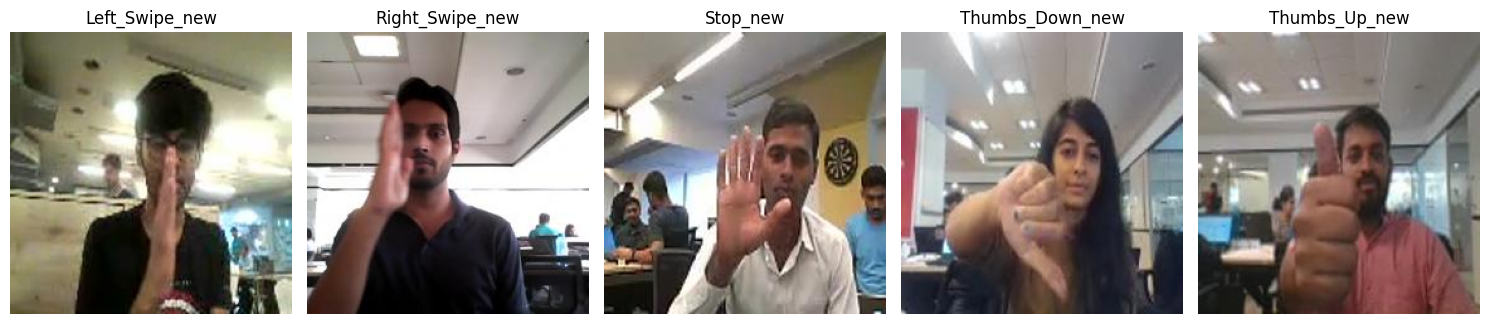

In [77]:
# Define a function to visualize data
def visualize_single_video_from_each_class(training_set_path):
    # Set up a figure with subplots for each class
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop over each class (0 to 4)
    for class_id in range(5):
        class_folder_path = os.path.join(training_set_path, str(class_id))

        # Get all video folders in this class
        video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]

        # Choose a random video folder
        random.seed(1)
        selected_video_folder = random.choice(video_folders)
        video_folder_path = os.path.join(class_folder_path, selected_video_folder)

        # Get all frames (images) in the selected video folder
        frames = [f for f in sorted(os.listdir(video_folder_path)) if f.endswith('.jpg')]

        # Select the middle frame
        middle_frame_path = os.path.join(video_folder_path, frames[len(frames) // 2])

        # Open and display the middle frame
        middle_frame = Image.open(middle_frame_path)
        axes[class_id].imshow(np.array(middle_frame))  # Convert to numpy array and plot
        axes[class_id].axis('off')  # Hide axis
        axes[class_id].set_title(f"{class_dict[class_id]}")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Visualize a single video from each class in the training set
visualize_single_video_from_each_class('jesture/training_set_resized')

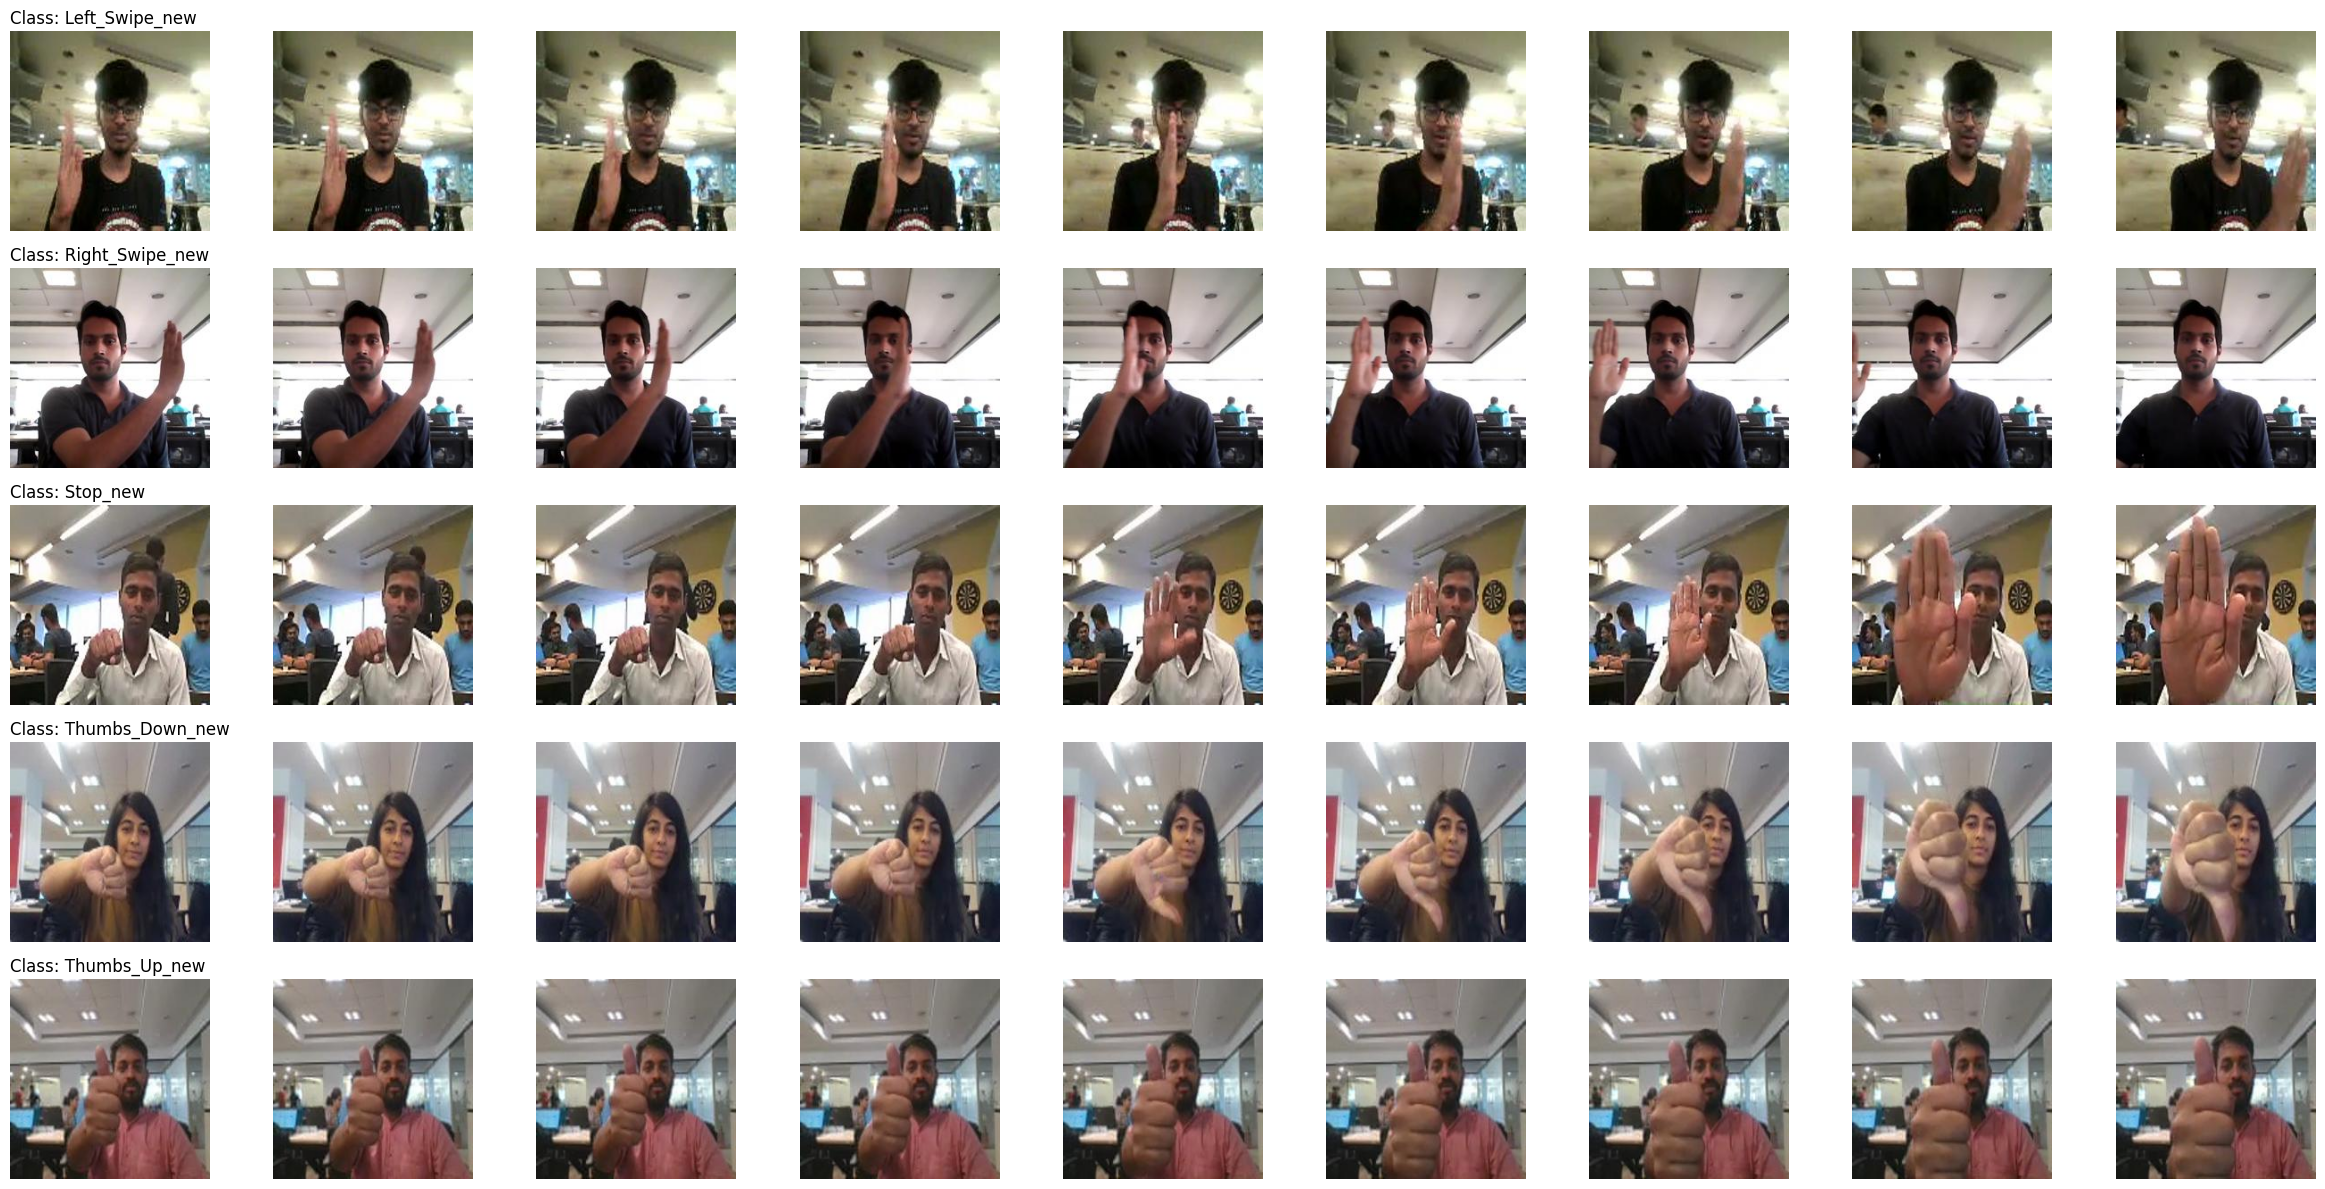

In [79]:
def visualize_9_frames_per_class(training_set_path):
    # Set up a figure with subplots (5 rows for classes, 9 columns for frames)
    fig, axes = plt.subplots(5, 9, figsize=(24, 12))  # 5x9 grid

    for class_id in range(5):
        class_folder_path = os.path.join(training_set_path, str(class_id))

        # Get all video folders in this class
        video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]

        # Choose a random video folder
        random.seed(1)  # Set seed for reproducibility
        selected_video_folder = random.choice(video_folders)
        video_folder_path = os.path.join(class_folder_path, selected_video_folder)

        # Get all frames (images) in the selected video folder
        frames = [f for f in sorted(os.listdir(video_folder_path)) if f.endswith('.jpg')]

        # Select 6 evenly spaced frames
        total_frames = len(frames)
        selected_frame_indices = np.linspace(0, total_frames - 1, 9, dtype=int)  # Indices of 9 frames

        for frame_idx, ax in zip(selected_frame_indices, axes[class_id]):
            frame_path = os.path.join(video_folder_path, frames[frame_idx])
            frame = Image.open(frame_path)

            # Display the frame in the corresponding subplot
            ax.imshow(np.array(frame))  # Convert to numpy array and plot
            ax.axis('off')  # Hide axis

        # Set the title for the first frame of each row (class)
        axes[class_id, 0].set_title(f"Class: {class_dict[class_id]}", loc='left', fontsize=12)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Visualize 9 frames per class in the training set
visualize_9_frames_per_class('jesture/training_set_resized')

Now, visualize a frames sequence associated to a random video:

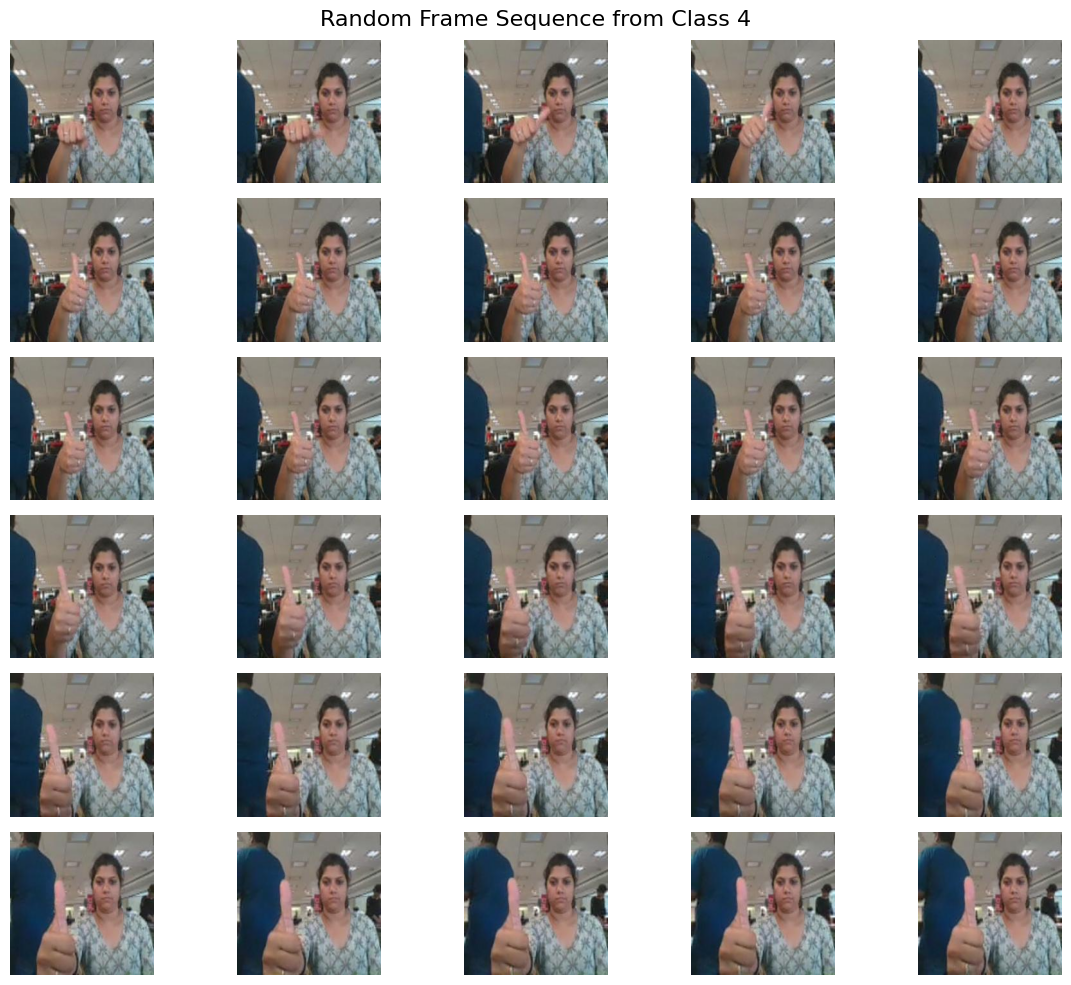

In [80]:
# Function to get a sequence of frames from a given video folder
def get_frame_sequence(class_folder_path):
    # Choose a random video folder from the class folder
    video_folders = [f for f in os.listdir(class_folder_path) if os.path.isdir(os.path.join(class_folder_path, f))]
    random.seed(123)
    selected_video_folder = random.choice(video_folders)
    video_folder_path = os.path.join(class_folder_path, selected_video_folder)

    # Get all frame files from the selected video folder
    frames = [f for f in sorted(os.listdir(video_folder_path)) if f.endswith('.jpg')]

    # Open and return the frames as a list of images
    frame_images = [Image.open(os.path.join(video_folder_path, frame)) for frame in frames]

    return frame_images

# Choose a random class (0 to 4)
class_id = random.randint(0, 4)

# Get the sequence of frames for a random video from the chosen class
frame_sequence = get_frame_sequence(os.path.join('jesture/training_set_resized', str(class_id)))

# Calculate the grid size (6x5)
rows = 6
cols = 5

# Ensure the number of frames doesn't exceed the available grid slots
max_frames = rows * cols
frame_sequence = frame_sequence[:max_frames]

# Plot the sequence of frames in a 6x5 grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Display each frame in the sequence
for ax, frame in zip(axes, frame_sequence):
    ax.imshow(frame)
    ax.axis('off')

# Set the title for the plot
plt.suptitle(f"Random Frame Sequence from Class {class_id}", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## **<font style="color:rgb(0, 133, 202)">5. Data Preparation for Modeling</font>**

Now, prepare and process the dataset for training and testing the gesture recognition models. The process involves:
1.	**Reading video data** organized by class folders, where each gesture corresponds to a specific class.
2.	**Preprocessing the frames** by resizing them to 64x64 pixels and normalizing their pixel values to the range [0, 1].
3.	**Converting videos into arrays** of 30 sequential frames, with each video labeled according to its class.
4.	**Encoding the labels** using one-hot encoding to make them compatible with the classification task.

This ensures that the data is formatted properly for input into deep learning models.

In [81]:
# Import data to avoid running everything again
def prepare_data(data_dir, num_classes):
    data = []  # Array for the videos
    labels = []  # Array for the labels

    for class_index in range(num_classes):
        class_path = os.path.join(data_dir, str(class_index))

        # Iterate over the videos of this class
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            frames = []

            # Sort the video frames and load them
            for frame in sorted(os.listdir(video_path)):
                frame_path = os.path.join(video_path, frame)
                img = load_img(frame_path, target_size=(64, 64))  # Load and resize
                img_array = img_to_array(img) / 255.0  # Normalize the pixels
                frames.append(img_array)

            # Add the video (30 frames) to the data
            data.append(np.array(frames))
            labels.append(class_index)

    # Convert everything to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    # One-hot encoding for the labels
    labels = to_categorical(labels, num_classes=num_classes)

    return data, labels

# Create Arrays
train_dir = "jesture/training_set_resized"
validation_dir = "jesture/test_set_resized"
num_classes = 5

X_train, y_train = prepare_data(train_dir, num_classes)
X_test, y_test = prepare_data(validation_dir, num_classes)

Check training and test set arrays' dimensions.

In [82]:
X_train.shape, y_train.shape

((663, 30, 64, 64, 3), (663, 5))

In [83]:
X_test.shape, y_test.shape

((100, 30, 64, 64, 3), (100, 5))

Save arrays in case of recovery.

In [ ]:
# Save data in .npy format
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

## **<font style="color:rgb(0, 133, 202)">6. Data Augmentation</font>**

Load data saved previously.

In [ ]:
# Import data
def load_data():
    # Load data from .npy file
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")
    X_test = np.load("X_val.npy")
    y_test = np.load("y_val.npy")

    print("Data loaded successfully!")
    return X_train, y_train, X_test, y_test

# Apply the function to extract data
X_train, y_train, X_test, y_test = load_data()

Data loaded successfully!


Since the dataset contains a limited number of videos, applying **data augmentation techniques** is essential to improve the training process of the models by artificially increasing the diversity of the data. **Data augmentation** refers to the process of applying transformations to the existing dataset to create new, slightly altered versions of the data, which helps the model generalize better and reduces the risk of overfitting.

To achieve this, the function `augment_video_safe` is implemented, performing a series of data augmentation transformations on a sequence of video frames while ensuring their horizontal orientation remains unchanged. These transformations include:
-	**Brightness Adjustment**: Randomly modifies frame brightness to simulate varying lighting conditions.
-	**Contrast Adjustment**: Adjusts contrast within a defined range to introduce variability in frame appearance.
-	**Central Cropping**: Focuses on the central region of the frame by cropping random portions, mimicking zoom effects.
-	**Zoom Simulation**: Simulates zooming in or out by resizing with padding and subsequent cropping.
-	**JPEG Quality Adjustment**: Randomly degrades JPEG quality to introduce compression artifacts.

Each transformation is applied probabilistically, ensuring variability in the data while preserving the frame’s original dimensions. The final output is a numpy array of augmented frames, normalized to the range [0, 1], with a consistent shape of 64x64x3, ready to be used as input for the model.

In [41]:
# Data augmentation function without horizontal flip
def augment_video_safe(video_frames):
    augmented_frames = []
    for frame in video_frames:
        frame = tf.convert_to_tensor(frame)  # Ensure that frame is a tensor
        if random.random() < 0.5:
            frame = tf.image.random_brightness(frame, max_delta=0.1)  # Brightness
        if random.random() < 0.5:
            frame = tf.image.random_contrast(frame, lower=0.9, upper=1.1)  # Contrast
        if random.random() < 0.5:
            frame = tf.image.central_crop(frame, central_fraction=random.uniform(0.8, 1.0))  # Random crop
        if random.random() < 0.5:
            frame = tf.image.resize_with_crop_or_pad(frame, 70, 70)  # Zoom (padding added)
            frame = tf.image.random_crop(frame, size=(64, 64, 3))  # Resize to original format
        if random.random() < 0.5:
            frame = tf.image.random_jpeg_quality(frame, 75, 100)  # Simulate jpeg quality

        # Force the frame size to (64, 64, 3)
        frame = tf.image.resize(frame, (64, 64))  # Ensure the size is 64x64
        frame = tf.clip_by_value(frame, 0.0, 1.0)  # Clip values between 0 and 1
        augmented_frames.append(frame)  # Remove numpy() on frame, which is already an ndarray

    return np.array(augmented_frames)

In [42]:
# Split the training set in a small training and validation sets
X_train_original, X_val, y_train_original, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

In [43]:
X_train_original.shape, X_val.shape

((464, 30, 64, 64, 3), (199, 30, 64, 64, 3))

In [44]:
# Function to apply augmentation to the data
def apply_augmentation(X_train_original, y_train_original):
    augmented_data = []
    augmented_labels = []

    for video, label in zip(X_train_original, y_train_original):
        # Apply data augmentation to each video
        augmented_video = augment_video_safe(video)
        augmented_data.append(augmented_video)
        augmented_labels.append(label)

    # Combine the original and augmented data
    X_train_augmented = np.concatenate((X_train_original, np.array(augmented_data)))
    y_train_augmented = np.concatenate((y_train_original, np.array(augmented_labels)))

    return X_train_augmented, y_train_augmented

# Apply augmentation only to the training data
X_train_augmented, y_train_augmented = apply_augmentation(X_train_original, y_train_original)

# Save the augmented data
np.save("X_train_augmented.npy", X_train_augmented)
np.save("y_train_augmented.npy", y_train_augmented)

In [45]:
# Check output dimensions
X_train_augmented = np.load("X_train_augmented.npy")
y_train_augmented = np.load("y_train_augmented.npy")
print(X_train_augmented.shape, y_train_augmented.shape)

(928, 30, 64, 64, 3) (928, 5)


## **<font style="color:rgb(0, 133, 202)">7. Training from Scratch LRCN: Conv2D + LSTM</font>**

The **LRCN** (*Long-term Recurrent Convolutional Network*) is a hybrid deep learning model designed to process sequential data, particularly for video-based tasks like action recognition or gesture classification. This implementation combines **Convolutional Neural Networks** (CNNs) to extract spatial features from individual video frames with a **Long Short-Term Memory** (LSTM) network to capture temporal dependencies across the sequence.

In [ ]:
# Configurations
num_classes = y_train_augmented.shape[1]  # Number of Catgeories
input_shape = X_train_augmented.shape[1:] # Frame per Video

num_classes, input_shape

(5, (30, 64, 64, 3))

### **<font style="color:rgb(0, 133, 202)">Construct the Model</font>**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def lrcn4(num_classes, input_shape):

    # Initialize a Sequential model
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    # CNN layers with TimeDistributed wrapper
    model.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.02)),
                              input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.02))))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    # Flatten layer to feed into LSTM
    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))

    # Dense layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    ########################################################################################################################

    # Display the model's summary
    model.summary()

    # Return the constructed LRCN model
    return model

**<font style="color:rgb(0, 133, 202)">Key Features of the Architecture</font>**

**TimeDistributed CNN Layers:**
-	The model uses TimeDistributed wrappers to apply 2D convolutional layers (Conv2D) to each frame in a video sequence independently.
-	Batch Normalization and MaxPooling layers are included to enhance training stability and reduce spatial dimensions, respectively.
-	Dropout regularization is applied after pooling to reduce overfitting.
-	Two CNN blocks extract increasingly complex spatial features from video frames.

**Flattening Spatial Features:** A TimeDistributed Flatten layer is used to reshape the spatial feature maps into a format suitable for feeding into the LSTM layer.

**LSTM Layer:** A single LSTM layer captures the temporal relationships between consecutive frames in the sequence. Dropout and recurrent dropout are applied to regularize the network and prevent overfitting on temporal patterns.

**Dense Output Layer:** A fully connected (Dense) layer with a softmax activation function produces the final classification probabilities for the num_classes target categories.

The CNN layers incorporate `L2 regularization` to penalize large weights, promoting better generalization and robustness. During training, this regularization technique proved essential in mitigating overfitting and significantly enhancing the model’s accuracy.

The model accepts video sequences with the shape (time_steps, height, width, channels), where each frame is resized to the desired spatial dimensions (e.g., 64x64x3). The model outputs probabilities for each of the num_classes, making it suitable for multi-class classification tasks.

Then, the function **`lrcn4()`** can be used to build the required LRCN model.

In [ ]:
# Construct the required LRCN model.
lrcn4 = lrcn4(num_classes, input_shape)

# Display the success message.
print("Model Created Successfully!")

/Users/sara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_36             │ (None, 30, 64, 64, 8)  │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 30, 64, 64, 8)  │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 30, 32, 32, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 30, 32, 32, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 30, 32, 32, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 30, 32, 32, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 30, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 30, 4096)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │       528,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 530,165 (2.02 MB)

 Trainable params: 530,117 (2.02 MB)

 Non-trainable params: 48 (192.00 B)

Model Created Successfully!


### **<font style="color:rgb(0, 133, 202)">Compile & Train the Model</font>**


After checking the structure, it is possible to start with compiling and training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
lrcn4.compile(loss = 'categorical_crossentropy',
                   optimizer = keras.optimizers.Adam(),
                   metrics = ["accuracy"])

In [ ]:
# Start training the model.
lrcn4_training_history = lrcn4.fit(x = X_train_augmented, y = y_train_augmented, epochs = 20, batch_size = 32,
                                             validation_data = (X_val, y_val), shuffle = True, callbacks = [early_stopping_callback])

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.2708 - loss: 1.8941 - val_accuracy: 0.4322 - val_loss: 1.5550
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.5876 - loss: 1.4183 - val_accuracy: 0.4824 - val_loss: 1.4946
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.6504 - loss: 1.2207 - val_accuracy: 0.6080 - val_loss: 1.2743
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.7815 - loss: 0.9576 - val_accuracy: 0.6231 - val_loss: 1.2049
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.8288 - loss: 0.8588 - val_accuracy: 0.6482 - val_loss: 1.0838
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.8525 - loss: 0.7553 - val_accuracy: 0.7186 - val_loss: 1.0644
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.8896 - loss: 0.6422 - val_accuracy: 0.7035 - val_loss: 0.9887
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9188 - loss: 0.5553 - val_accuracy: 0.6935 - v

Here are the most relevant values to mention:
1.	**Initial Performance (Baseline) - Epoch 1:**
    -	Training Accuracy: 27.08%
    -	Validation Accuracy: 43.22%
    -	Training Loss: 1.8941
    -	Validation Loss: 1.5550

2.	**Best Validation Accuracy Achieved - Epoch 19:**
    -	Validation Accuracy: 74.37%
    -	Validation Loss: 0.8654

3.	**Final Model Performance (Last Epoch) - Epoch 20:**
    -	Training Accuracy: 99.86%
    -	Validation Accuracy: 71.86%
    -	Training Loss: 0.1931
    -	Validation Loss: 0.9525

4.	**Overfitting Observations:**
    -	The training accuracy reached nearly 100%, while validation accuracy peaked at 74.37% but dropped slightly in the last epoch to 71.86%.
    -	Validation loss initially decreased but fluctuated in later epochs, indicating overfitting.

5.	**Learning Highlights:**
    -	Validation accuracy improved significantly from 43.22% to 74.37% over 19 epochs.
    -	Despite overfitting signs, the model demonstrated improved generalization with a best validation loss of 0.8654.

### **<font style="color:rgb(0, 133, 202)">Evaluating the trained Model</font>**

Now, it is possible to evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = lrcn4.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7448 - loss: 0.8833


### **<font style="color:rgb(0, 133, 202)">Plot Model’s Loss & Accuracy Curves</font>**

Visualize how the training and validation metrics of this model have evolved over the epochs.

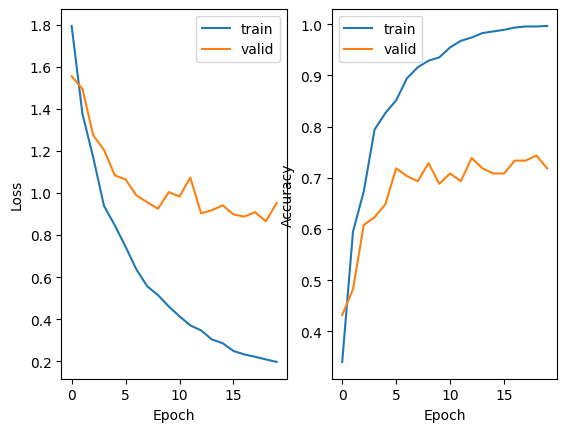

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(lrcn4_training_history.history['loss'])
plt.plot(lrcn4_training_history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(lrcn4_training_history.history['accuracy'])
plt.plot(lrcn4_training_history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

A pronounced **overfitting phenomenon** can be clearly observed. Initially, there is an improvement in performance for both the training and validation sets. While the training accuracy continues to grow, surpassing 90%, the validation accuracy stabilizes at around 70%. This overfitting is most likely due to the model needing better training, particularly with a larger dataset—something that the available resources cannot support.

To address this limitation, a potential future development would be to apply transfer learning techniques. This involves leveraging a pre-trained model to capture key features, then adding an LSTM layer to capture the temporal sequence of video frames. This approach would allow the use of a pre-trained model on a larger dataset, removing the classification layer, and adapt it to the specific problem at hand, focusing on the most important features.

Despite the aforementioned challenges, the model’s performance should still be considered reasonably acceptable, particularly given that it was manually implemented.

### **<font style="color:rgb(0, 133, 202)">Save the Model</font>**

After that, save the model for future uses.

In [ ]:
os.makedirs('lrcn4')
lrcn4.save('lrcn4/lrcn4.keras')
lrcn4.save_weights('lrcn4/lrcn4_weights.weights.h5')

### **<font style="color:rgb(0, 133, 202)">Contingency table</font>**
Finally, load the trained model and compare classification predictions with actual labels, visualizing them in a contingency matrix.

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 667ms/step


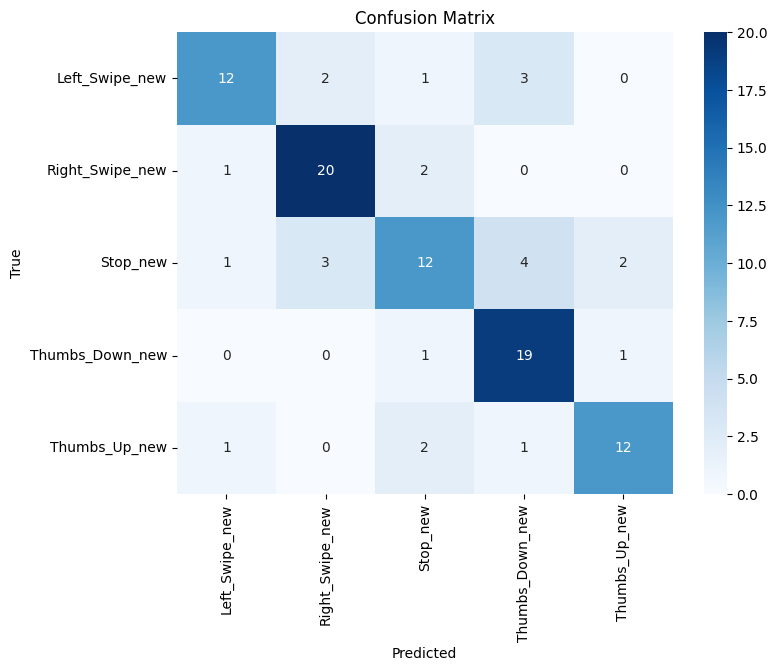

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

lrcn_mod2 = load_model('lrcn4/lrcn4.keras')

# Predizioni del modello
predictions = lrcn_mod2.predict(X_test)

# Converti le previsioni da one-hot encoded a etichetta di classe
predictions = np.argmax(predictions, axis=1)  # Previsioni in formato indice di classe

# Converti le etichette reali da one-hot a etichetta di classe
y_test_labels = np.argmax(y_test, axis=1)  # Etichette reali in formato indice di classe

# Genera la matrice di contingenza
conf_matrix = confusion_matrix(y_test_labels, predictions)
class_dict = {1: 'Right_Swipe_new',
 3: 'Thumbs_Down_new',
 0: 'Left_Swipe_new',
 2: 'Stop_new',
 4: 'Thumbs_Up_new'}

# Visualizza la matrice di contingenza come heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[class_dict[i] for i in range(num_classes)],
            yticklabels=[class_dict[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

On the test set, the model achieves an accuracy of nearly **75%**, which is a reasonably satisfactory result, especially considering other previous attempts (omitted). Upon analyzing the confusion matrix, the classes with the highest error rates are *Stop* and *Left Swipe*, with errors distributed across almost all other gesture classes. Given the limited data available, although the number of absolute errors may seem low, the proportion relative to the size of the classes is not insignificant. This further reinforces the need for a larger dataset to improve the model’s performance.

## **<font style="color:rgb(0, 133, 202)">8. Transfer Learning: MobileNetV2 + LSTM</font>**

Given the suboptimal performance of the model trained from scratch, a decision was made to **leverage transfer learning** while retaining the manually crafted model structure. This approach uses a pre-trained backbone to extract high-level features and integrates them into the temporal sequence processing framework, to capture temporal sequentiality.

In [ ]:
# Configurations
num_classes = y_train_augmented.shape[1]  # Number of Catgeories
input_shape = X_train_augmented.shape[1:] # Frame per Video

num_classes, input_shape

(5, (30, 64, 64, 3))

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D

# Modello pre-addestrato (backbone)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape[1:])

# Costruzione del modello con TimeDistributed
model = Sequential()

# TimeDistributed per applicare il backbone a ogni frame
model.add(TimeDistributed(base_model, input_shape=input_shape))  # Sequenza di 30 frame
model.add(TimeDistributed(GlobalAveragePooling2D()))  # Riduce dimensionalità delle feature

# LSTM per analizzare la sequenza temporale
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))

# Layer denso per la classificazione
model.add(Dense(num_classes, activation='softmax'))

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Sommario del modello
model.summary()

/var/folders/w7/0xpq0vds7cz2333831nfq5dc0000gn/T/ipykernel_10856/931250419.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape[1:])
/Users/sara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 30, 2, 2, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │       168,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,213 (9.26 MB)

 Trainable params: 2,392,101 (9.13 MB)

 Non-trainable params: 34,112 (133.25 KB)

The resulting model structure is as follows:
1.	**Feature Extraction Backbone**: The pre-trained MobileNetV2, trained on ImageNet, is employed as the backbone. Its top layers are removed (`include_top=False`) to focus on feature extraction. Each frame of the input sequence is passed through this backbone using a `TimeDistributed wrapper`, ensuring consistent feature extraction for all frames.

2.	**Global Feature Reduction**: After feature extraction, a `GlobalAveragePooling2D` layer is applied to each frame (via TimeDistributed). This step reduces feature dimensionality while preserving spatial information, creating a compact and efficient feature representation.

3.	**Temporal Sequence Analysis**: The temporal dynamics of the video are captured by an `LSTM` layer with 32 filters. The LSTM processes the extracted frame features, leveraging its ability to model temporal dependencies. Dropout and recurrent dropout (both set to 0.5) are applied to prevent overfitting.

4.	**Classification**: The final Dense layer maps the LSTM outputs to the number of target classes using a softmax activation, producing a probability distribution for classification.

In [ ]:
# Addestramento
history = model.fit(X_train_augmented, y_train_augmented,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    shuffle=True)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.3842 - loss: 1.3918 - val_accuracy: 0.2814 - val_loss: 1.7803
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.8494 - loss: 0.5160 - val_accuracy: 0.7186 - val_loss: 0.8666
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9461 - loss: 0.2116 - val_accuracy: 0.7889 - val_loss: 0.8126
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 0.9460 - loss: 0.1733 - val_accuracy: 0.7638 - val_loss: 0.8287
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.9568 - loss: 0.1593 - val_accuracy: 0.7739 - val_loss: 0.9405
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.9453 - loss: 0.2030 - val_accuracy: 0.8141 - val_loss: 0.6885
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.9613 - loss: 0.1407 - val_accuracy: 0.8894 - val_loss: 0.3389
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.9751 - loss: 0.0819 - val_accuracy: 0.8643 - v

Here are the most relevant values to mention:

1.	**Initial Performance (Baseline) - Epoch 1:**
    - Training Accuracy: 38.42%
    - Validation Accuracy: 28.14%
    - Training Loss: 1.3918
    - Validation Loss: 1.7803
    
2.	**Best Validation Accuracy Achieved - Epoch 19:**
    -	Validation Accuracy: 94.47%
    -	Validation Loss: 0.2315

3.	**Final Model Performance (Last Epoch) - Epoch 20:**
    -	Training Accuracy: 99.37%
    -	Validation Accuracy: 92.46%
    -	Training Loss: 0.0234
    -	Validation Loss: 0.3730

4.	**Overfitting Observations:**
    -	The training accuracy reached 99%+, while validation accuracy stabilized around 92-94% in later epochs.
    -	Validation loss fluctuated slightly but remained low, suggesting some generalization issues might persist.

5.	**Learning Highlights:**
-	Significant improvement from 28% to 94% validation accuracy over 20 epochs.
-	Low validation loss (best: 0.2315) indicates the model is effective at classifying gestures.


### **<font style="color:rgb(0, 133, 202)">Evaluating the trained Model</font>**

Now, it is possible to evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - accuracy: 0.9321 - loss: 0.2708


### **<font style="color:rgb(0, 133, 202)">Plot Model’s Loss & Accuracy Curves</font>**

Visualize how the training and validation metrics of this model have evolved over the epochs.

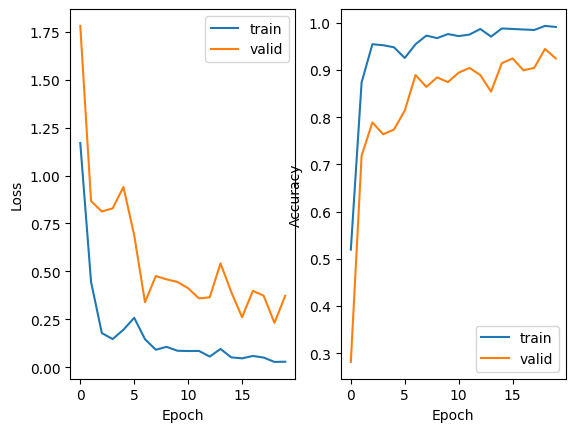

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Compared to the previous case, a significant improvement in performance can be observed. Accuracy on the training set consistently remains slightly higher than on the validation set, but the gap gradually narrows as the epochs progress. Furthermore, not only is there a substantial reduction in the overfitting observed in the model built from scratch, but there is also a remarkable improvement in the overall accuracy of the model, making it significantly more effective.

### **<font style="color:rgb(0, 133, 202)">Save the Model</font>**

After that, save the model for future uses.

In [ ]:
os.makedirs('model_tl')
model.save('model_tl/model_tl.keras')
model.save_weights('model_tl/model_tl_weights.weights.h5')

### **<font style="color:rgb(0, 133, 202)">Contingency table</font>**

Finally, load the trained model and compare classification predictions with actual labels, visualizing them in a contingency matrix.

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step 


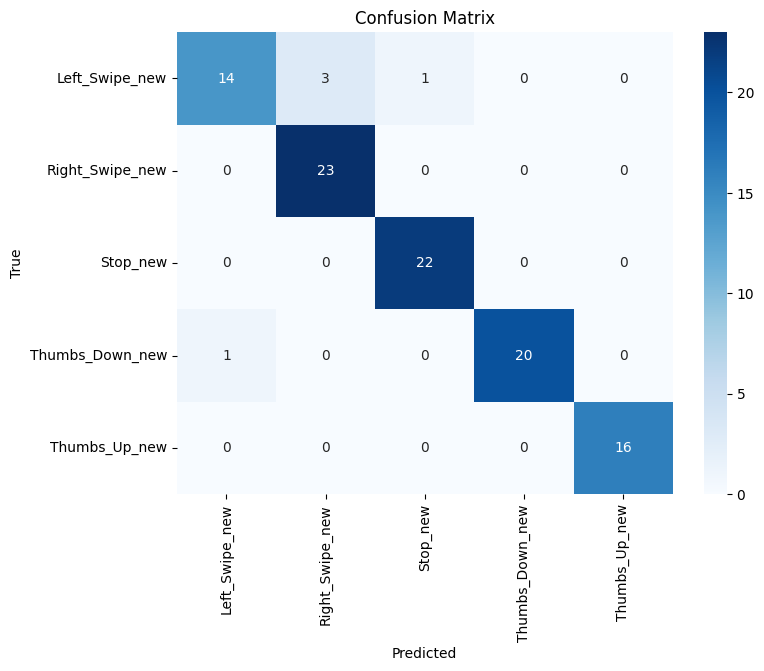

In [ ]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

model_tl = load_model('model_tl/model_tl.keras')

# Predizioni del modello
predictions = model_tl.predict(X_test)

# Converti le previsioni da one-hot encoded a etichetta di classe
predictions = np.argmax(predictions, axis=1)  # Previsioni in formato indice di classe

# Converti le etichette reali da one-hot a etichetta di classe
y_test_labels = np.argmax(y_test, axis=1)  # Etichette reali in formato indice di classe

# Genera la matrice di contingenza
conf_matrix = confusion_matrix(y_test_labels, predictions)
class_dict = {1: 'Right_Swipe_new',
 3: 'Thumbs_Down_new',
 0: 'Left_Swipe_new',
 2: 'Stop_new',
 4: 'Thumbs_Up_new'}

# Visualizza la matrice di contingenza come heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[class_dict[i] for i in range(num_classes)],
            yticklabels=[class_dict[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The results on the test set are truly remarkable, with an **accuracy** of **93%**. Only a few misclassifications are observed: three cases of left swipe misclassified as right swipe, one as stop, and a single instance where thumbs down is misclassified as left swipe.

## **<font style="color:rgb(0, 133, 202)">9. Conclusions</font>**

The implementation of an LRCN model from scratch highlights the challenges of training deep learning models on limited datasets. The pronounced overfitting suggests that the model effectively learns patterns in the training data but struggles to generalize to unseen samples. While achieving a reasonable accuracy of 75% on the test set, misclassifications—especially between similar gestures—indicate the need for more data or alternative learning strategies. Transfer learning emerges as a natural solution, leveraging pre-trained models to extract meaningful features while reducing the risk of overfitting.

Integrating transfer learning significantly improves performance, leading to a more balanced model with reduced overfitting and better generalization. The accuracy boost to 93% on the test set demonstrates the effectiveness of this approach, confirming that leveraging pre-trained feature extractors alongside an LSTM-based sequence model can enhance gesture recognition.

During the simulation of a demo, where models were tested on gestures performed by different users, a high sensitivity to variations in movements, hand positioning relative to the face, and framing within the bounding box was observed. Empirical and subjective sample checks revealed that most individuals performing gestures wore sleeveless clothing, which may pose recognition difficulties when a covered arm is introduced. This highlights the importance of a large and diverse dataset, ensuring the model’s adaptability to different real-world conditions. Simple data augmentation alone cannot fully address these challenges, making the inclusion of a varied and heterogeneous population essential for improving robustness and versatility.

## **<font style="color:rgb(0, 133, 202)">References</font>**

Dataset: https://www.kaggle.com/datasets/imsparsh/gesture-recognition 

Transfer Learning: https://keras.io/api/applications/mobilenet/ 

MobileNet V2: https://paperswithcode.com/method/mobilenetv2 

Data Augmentation: https://github.com/okankop/vidaug 

LRCN Model: https://kobiso.github.io/research/research-lrcn/

Trained Models and Video Demo: https://drive.google.com/drive/folders/1aKzl8kzWTJ71iBL80L3PjGbsL_n9M8S8?usp=share_link